In [ ]:
# Needs hdf5 to run
# Instead of hf datasets lib alternatively use torchgeo 
# As of 02.11.24 failed to reach geo API, could attempt later
%pip install --upgrade torch; torchvision; datasets; h5py

In [ ]:
# Copyright 2020 The HuggingFace Datasets Authors and the current dataset script contributor.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

import os
from typing import List
import torch
import datasets
# from torchgeo.datasets import CaBuAr
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.transforms import functional as F
import h5py
import numpy as np

# Find for instance the citation on arxiv or on the dataset repo/website
_CITATION = """\
@article{cabuar,
  title={Ca{B}u{A}r: California {B}urned {A}reas dataset for delineation},
  author={Rege Cambrin, Daniele and Colomba, Luca and Garza, Paolo},
  journal={IEEE Geoscience and Remote Sensing Magazine},
  doi={10.1109/MGRS.2023.3292467},
  year={2023}
}
"""

# You can copy an official description
_DESCRIPTION = """\
CaBuAr dataset contains images from Sentinel-2 satellites taken before and after a wildfire.
The ground truth masks are provided by the California Department of Forestry and Fire Protection and they are mapped on the images.
"""

_HOMEPAGE = "https://huggingface.co/datasets/DarthReca/california_burned_areas"

_LICENSE = "OPENRAIL"

# Define the root directory for the dataset
# Change manually
_URLS = {'root': os.curdir,'cache_dir':"/raw"}
_BATCH_SIZE = 16
_NUM_WORKERS = 1


In [ ]:
# Set the Hugging Face datasets cache directory
os.environ['HF_DATASETS_CACHE'] = os.path.join(_URLS['root'],_URLS['cache_dir'])


# You can verify by printing (optional)
print(f"HF_DATASETS_CACHE set to: {os.getenv('HF_DATASETS_CACHE')}")

In [5]:
# Define device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
# Load the CaBuAr dataset
# Possible splits: 1-5, or chabud
# For docs check out 
# https://huggingface.co/datasets/DarthReca/california_burned_areas
# https://torchgeo.readthedocs.io/en/stable/api/datasets.html#cabuar 
dataset = datasets.load_dataset('DarthReca/california_burned_areas', name='pre-post-fire', split='chabud',trust_remote_code=True)


In [7]:
# Define transformations (modify as needed)
transform = transforms.Compose([
    transforms.Lambda(np.array), # List converts to numpy array
    transforms.ToTensor(),  # Converts numpy arrays to torch tensors
    # Add more transforms if necessary, e.g., normalization
    # transforms.Normalize(mean=[0.5], std=[0.5]),
])

In [8]:
# Define a custom PyTorch Dataset to apply transformations
class CaBuArPyTorchDataset(datasets.GeneratorBasedBuilder):
    def __init__(self, hf_dataset, transform=None, load_prefire=True):
    # Commented - Alternative def using torchgeo parent class
    #def __init__(self, root, transform=None, download = False):
        """
        Args:
            hf_dataset: Hugging Face dataset object
            transform: Optional transform to be applied on a sample
            load_prefire: Boolean indicating whether to load pre_fire data
            download: if True, download dataset and store it in the root directory
        """
        # super().__init__(root=root, transforms=transform, download=download)
        self.hf_dataset = hf_dataset
        self.transform = transform
        self.load_prefire = load_prefire

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        sample = self.hf_dataset[idx]
        post_fire = sample['post_fire']  # Shape: (512, 512, 12)
        mask = sample['mask']            # Shape: (512, 512, 1)

        if self.load_prefire:
            pre_fire = sample.get('pre_fire', np.zeros_like(post_fire))
        else:
            pre_fire = None

        # Apply transformations
        if self.transform:
            post_fire = self.transform(post_fire)
            mask = self.transform(mask)
            if pre_fire is not None:
                pre_fire = self.transform(pre_fire)

        # Move tensors to device
        post_fire = post_fire.to(device)
        mask = mask.to(device)
        if pre_fire is not None:
            pre_fire = pre_fire.to(device)

        # Prepare the output dictionary
        if self.load_prefire:
            return {
                'post_fire': post_fire,    # Tensor: [12, 512, 512]
                'pre_fire': pre_fire,      # Tensor: [12, 512, 512]
                'mask': mask.squeeze(0)    # Tensor: [512, 512]
            }
        else:
            return {
                'post_fire': post_fire,    # Tensor: [12, 512, 512]
                'mask': mask.squeeze(0)    # Tensor: [512, 512]
            }

In [ ]:
import torch
from torch.utils.data import Dataset
from torchvision import transforms
import torch.nn.functional as F

class BurnedAreasDataset(Dataset):
    def __init__(self, pre_fire_images, post_fire_images, masks, transform=None):
        """
        Args:
            pre_fire_images (Tensor): Tensor of pre-fire images [B, 12, H, W]
            post_fire_images (Tensor): Tensor of post-fire images [B, 12, H, W]
            masks (Tensor): Binary masks [B, H, W]
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.pre_fire_images = pre_fire_images
        self.post_fire_images = post_fire_images
        self.masks = masks
        self.transform = transform
        
        # Define pre-processing transformations
        self.normalize = transforms.Normalize(mean=[0.485]*24, std=[0.229]*24)  # 24 channels after concatenation
        self.augmentations = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(degrees=15),
            transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.0)),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0)),
            transforms.ToTensor(),
            self.normalize,
        ])
    
    def calculate_ndvi(self, pre_fire, post_fire):
        # Assuming NIR is channel 4 and Red is channel 3 (0-indexed)
        pre_nir = pre_fire[:, 3, :, :]
        pre_red = pre_fire[:, 2, :, :]
        post_nir = post_fire[:, 3, :, :]
        post_red = post_fire[:, 2, :, :]
        
        ndvi_pre = (pre_nir - pre_red) / (pre_nir + pre_red + 1e-6)
        ndvi_post = (post_nir - post_red) / (post_nir + post_red + 1e-6)
        
        return ndvi_pre.unsqueeze(1), ndvi_post.unsqueeze(1)
    
    def compute_difference(self, pre_fire, post_fire):
        return post_fire - pre_fire  # Shape: [B, 12, H, W]
    
    def __len__(self):
        return len(self.pre_fire_images)
    
    def __getitem__(self, idx):
        pre_fire = self.pre_fire_images[idx]
        post_fire = self.post_fire_images[idx]
        mask = self.masks[idx]
        
        # Calculate NDVI
        ndvi_pre, ndvi_post = self.calculate_ndvi(pre_fire, post_fire)
        
        # Compute difference image
        diff_image = self.compute_difference(pre_fire, post_fire)
        
        # Concatenate pre-fire, post-fire, NDVI, difference
        combined_input = torch.cat([pre_fire, post_fire, ndvi_pre, ndvi_post, diff_image], dim=0)  # [24 + 1 + 1 + 12 = 38 channels]
        
        # Apply augmentations
        combined_input = combined_input.unsqueeze(0)  # Add batch dimension for transforms
        combined_input = self.augmentations(combined_input)
        combined_input = combined_input.squeeze(0)  # Remove batch dimension
        
        # Prepare mask
        mask = mask.float()  # or long, depending on loss function
        
        if self.transform:
            combined_input = self.transform(combined_input)
        
        return combined_input, mask

In [9]:
# Instantiate the custom dataset
pytorch_dataset = CaBuArPyTorchDataset(
    hf_dataset=dataset,
    transform=transform,
    load_prefire=True  # Set to False if you want to load only post_fire data
)
# pytorch_dataset = CaBuArPyTorchDataset(
#     root= _URLS['root'],
#     transform=transform,
#     download = False  # Set to False if you want to load only post_fire data
# )
# Create a DataLoader
dataloader = DataLoader(
    pytorch_dataset,
    batch_size=_BATCH_SIZE,       # Adjust batch size as needed
    shuffle=False,        # Shuffle for training
    num_workers=_NUM_WORKERS,       # Number of subprocesses for data loading
    pin_memory=True      # Speed up transfer to GPU
)

In [ ]:
# Example: Iterate through the DataLoader
for batch_idx, batch in enumerate(dataloader):
    post_fire = batch['post_fire']      # Shape: [batch_size, 12, 512, 512]
    mask = batch['mask']                # Shape: [batch_size, 512, 512]
    pre_fire = batch.get('pre_fire')    # Shape: [batch_size, 12, 512, 512] or None

    # Now you can pass `post_fire`, `pre_fire`, and `mask` to your model
    # Example:
    # outputs = model(post_fire, pre_fire)
    # loss = criterion(outputs, mask)

    # For demonstration, we'll just print the batch shapes
    print(f"Batch {batch_idx}:")
    print(f"  post_fire shape: {post_fire.shape}")
    if pre_fire is not None:
        print(f"  pre_fire shape: {pre_fire.shape}")
    print(f"  mask shape: {mask.shape}")

    # Break after first batch for demonstration
    if batch_idx == 0:
        break

# TODO
 - Create an class ratio graphic in output mask

 - **(Optional)** showcase density of classes on mask (how noisy is the data)

 - Extract spectre distribution on random images

 - Mean brightness, distribution from center of inputs

 - how **correlated** are adjacent 2d tensors in pre-fire, post-fire, could dataset be ordered by **time** if needed? 

## Dataset histogram per frequency layer

Important to know whether all layers are equally distributed on mean and variance

In [27]:
def calculate_histogram(image, bins=256):
    """
    Calculate histogram for each color channel of the image.
    
    Args:
        image (tensor): Image tensor of shape [C, H, W].
        bins (int): Number of bins for the histogram.
        
    Returns:
        hist (tensor): Histogram tensor of shape [C, bins].
    """
    hist = torch.zeros((image.size(0), bins))
    for c in range(image.size(0)):
        hist[c] = torch.histc(image[c], bins=bins, min=0, max=1)
    return hist

In [23]:
def mean_color_histogram(batch, bins=256):
    """
    Compute the mean color histogram for a batch of images.
    
    Args:
        batch (tensor): Batch of images of shape [B, C, H, W].
        bins (int): Number of bins for the histogram.
        
    Returns:
        mean_hist (tensor): Mean histogram tensor of shape [C, bins].
    """
    print(batch.size())
    print(batch[0].size())
    batch_size, channels, height, width = batch.size()
    histograms = torch.zeros((batch_size, channels, bins))
    
    for i in range(batch_size):
        histograms[i] = calculate_histogram(batch[i], bins=bins)
    
    mean_hist = histograms.mean(dim=0)
    return mean_hist

torch.Size([16, 12, 512, 512])
torch.Size([12, 512, 512])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])
torch.Size([256])


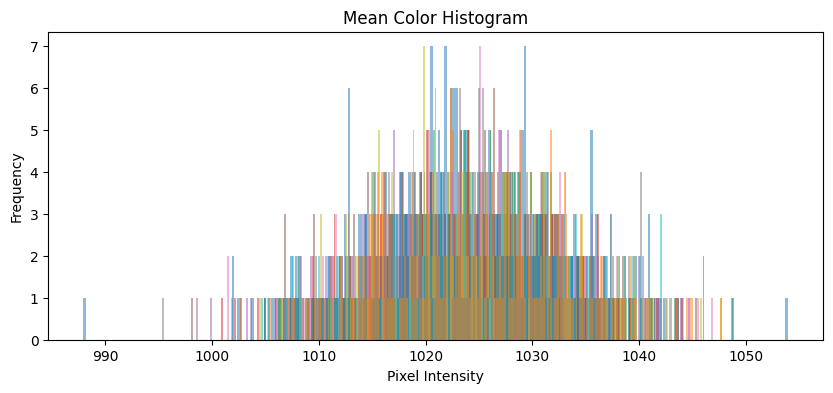

In [34]:
import matplotlib.pyplot as plt
# Example batch of images with random values and specified size [batch_size, channels, height, width]
batch_size = _BATCH_SIZE
channels = 12
height = 512
width = 512

# Generate random images (for demonstration)
batch = torch.rand((batch_size, channels, height, width))

# Calculate mean color histogram
bins = 256
mean_hist = mean_color_histogram(batch, bins=bins)

# Plot the mean color histogram
def plot_histogram(histogram, bins):
    colors = ['r', 'g', 'b']
    bin_edges = np.linspace(0, 1, bins + 1)
    
    plt.figure(figsize=(10, 4))
    for c in range(channels):
        print(histogram[c].size())
        # plt.plot(bin_edges[:-1], histogram[c].numpy(), color=colors[c], alpha=0.5)
        #plt.plot(bin_edges[:-1], histogram[c].numpy(), alpha=0.5)
        plt.hist(histogram[c].numpy(), bins=bins, alpha=0.5)


    plt.xlabel('Pixel Intensity')
    plt.ylabel('Frequency')
    plt.title('Mean Color Histogram')
    #plt.legend(['Red', 'Green', 'Blue'])
    plt.show()

plot_histogram(mean_hist, bins)

## Preprocessing functions



In [ ]:
def compute_difference(pre_fire, post_fire):
    return post_fire - pre_fire

def calculate_ndvi(pre_fire, post_fire):
    # Assuming NIR is channel 4 and Red is channel 3 (0-indexed)
    pre_nir = pre_fire[:, 3, :, :]
    pre_red = pre_fire[:, 2, :, :]
    post_nir = post_fire[:, 3, :, :]
    post_red = post_fire[:, 2, :, :]
    
    ndvi_pre = (pre_nir - pre_red) / (pre_nir + pre_red + 1e-6)
    ndvi_post = (post_nir - post_red) / (post_nir + post_red + 1e-6)
    
    return ndvi_pre, ndvi_post

def clip_values(image, min_val=0.0, max_val=1.0):
    return torch.clamp(image, min=min_val, max=max_val)

gaussian_blur = transforms.GaussianBlur(kernel_size=(3, 3), sigma=(0.1, 2.0))

def adjust_contrast(image, contrast_factor=1.5):
    return F.adjust_contrast(image, contrast_factor)

def rearrange_channels(pre_fire, post_fire):
    # Stack pre-fire and post-fire channels
    return torch.cat([pre_fire, post_fire], dim=1)  # Shape: [Batch, 24, H, W]

In [35]:
augmentations = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(degrees=15),
    transforms.RandomResizedCrop(size=(28, 28), scale=(0.8, 1.0)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
])

normalize = transforms.Normalize(mean=[0.485]*12, std=[0.229]*12)

In [ ]:
def preprocess_batch(pre_fire, post_fire, mask):
    # Clip values
    pre_fire = clip_values(pre_fire)
    post_fire = clip_values(post_fire)
    
    # Calculate NDVI or other indices
    ndvi_pre, ndvi_post = calculate_ndvi(pre_fire, post_fire)
    
    # Create difference image
    diff_image = compute_difference(pre_fire, post_fire)
    
    # Concatenate all features
    combined_input = torch.cat([pre_fire, post_fire, ndvi_pre.unsqueeze(1), ndvi_post.unsqueeze(1), diff_image.unsqueeze(1)], dim=1)
    
    # Normalize
    combined_input = normalize(combined_input)
    
    # Augment
    combined_input = augmentations(combined_input)
    
    # Prepare mask
    mask = mask.float()  # or long, depending on loss function
    
    return combined_input, mask

## Feature detectors

-Important to denoise the data,
compute **low** and **high** pass filters, using gaussian and laplacian blur pyramids

- quantile tresholding to find peaks

- Sebile kernel filter 
### Detect edges using derivative filters, canny edge detectors and hysteresis tresholding for edges

In [ ]:
# (Optional) Collect accuracy vector after training epochs
# Here, it's assumed you have a training loop where you collect accuracy

# Example training loop structure
def train_model(dataloader, model, criterion, optimizer, num_epochs=10):
    loss_vector = []
    accuracy_vector = []

    for epoch in range(1, num_epochs + 1):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch in dataloader:
            post_fire = batch['post_fire']
            mask = batch['mask']
            pre_fire = batch.get('pre_fire')

            # Move data to device
            post_fire = post_fire.to(device)
            mask = mask.to(device)
            if pre_fire is not None:
                pre_fire = pre_fire.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(post_fire, pre_fire) if pre_fire is not None else model(post_fire)
            loss = criterion(outputs, mask)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Statistics
            running_loss += loss.item() * post_fire.size(0)
            # Assuming outputs are logits; apply argmax to get predictions
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == mask).sum().item()
            total += mask.numel()

        epoch_loss = running_loss / len(pytorch_dataset)
        epoch_acc = 100. * correct / total
        loss_vector.append(epoch_loss)
        accuracy_vector.append(epoch_acc)

        print(f"Epoch {epoch}/{num_epochs}: Loss={epoch_loss:.4f}, Accuracy={epoch_acc:.2f}%")

    print("Training complete.")
    print("Accuracy vector:", accuracy_vector)
    return loss_vector, accuracy_vector